# This is the first cell to start and they must be run in order if you want good results

In [29]:
include("FunctionsHelper.jl") #my take on poly_helper
#This changed certain functions and got rid of unused ones otherwise it is a copy of poly_helper
#Note some types were changed to make coding easier
using Optim
seedForRandomness = 115;


58
[1.66696,0.948262,6.72605]
Made it through optimization according to percision
unverified
Made it through optimization according to percision
unverified
Made it through optimization according to percision
unverified
Made it through optimization according to percision
unverified


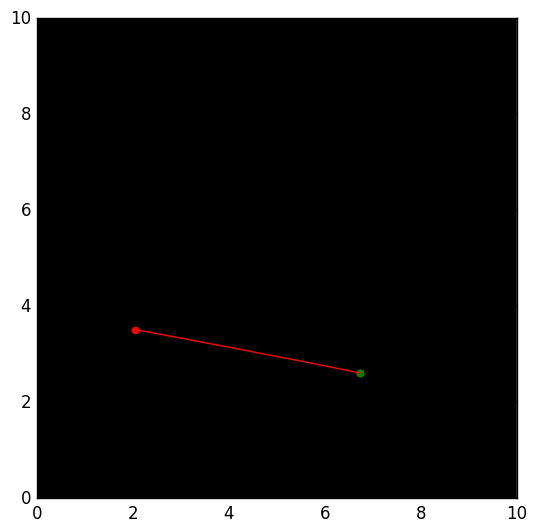

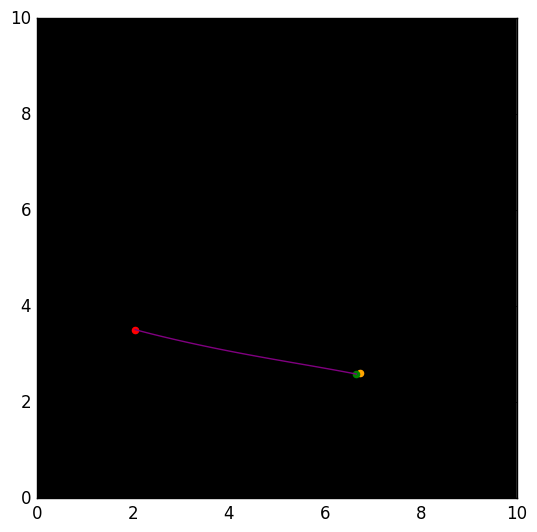

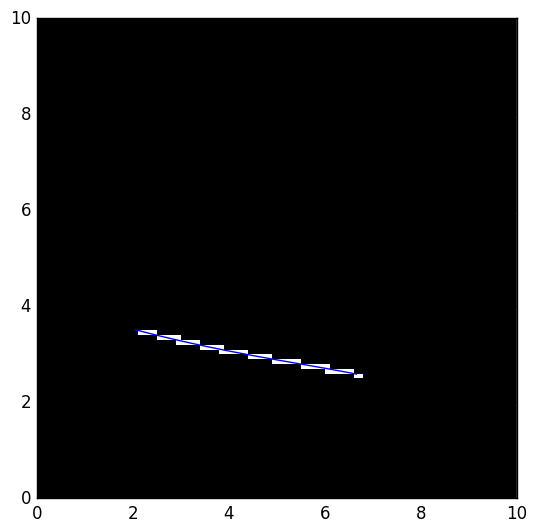

Made it through optimization according to percision
verified
Time of Path: 5.0


PyObject <matplotlib.image.AxesImage object at 0x000000002AAF1EF0>

In [40]:
#Function polyPathLocal creates a 7th order polynomial to be fit and optimized between the current copter configuration
# and a configuration on the global plan.
#Assumptions
# Default global path to plan to is Dijkstras
# Average distance for local planner is 10 meters
# Three initial conditions are known
#Inputs
# current_Pos - the initial positions x,y,z, yaw = p
# current_Vel - the initial velocities in x,y,z, yaw = p
# current_Accel - the initial accelerations in x,y,z, yaw = p
# final_Pos - the final positions in x,y,z, yaw = p
# final_Vel - te final velocities in x,y,z, yaw = p
# final_Accel - the final accelerations in x,y,z, yaw = p
# costmap - an array of values from 0-255 to designate cost of traveling in a certain square by obstacles
# q_coeffs - a vector of weights to be applied to the derivative costs
# obstacleWeight - the weight applied to the obstacles in the cost function
# flag - a boolean that will decide between dijkstras or FMT global planning assumption, true -> fmt
# perturbStep - the amount of distance to start the gradient descent
# iterations - number of iterations to optimize over
#Outputs
# polyPath - the coefficients of the polynomial of the planned path
#####################Testing Variables###########################################
#Create costmap
# Form a grid which shows the cells we check:
width = get_grid_extent();
res   = get_grid_resolution();
n = round(Int64,ceil(width/res));
seedForRandomness =58;
srand(seedForRandomness)
println(seedForRandomness)
#interesting seed:14, 15, 21,58, 115, 152,155, 157,189
costmap = zeros(n,n,n);
#Create a certain amount of objects
for tc = 1:20
    index1 = round(rand()*get_grid_extent()/get_grid_resolution());
    index2 = round(rand()*get_grid_extent()/get_grid_resolution());
    for l = 1:size(costmap,1)
        for p = 1:size(costmap,2)
            #costmap[l,p,1] += 255/(sqrt((l-index1)^2+(p-index2)^2));
            if(costmap[l,p,1]>255)
                costmap[l,p,1] = 255;
            end
        end
    end
end
#Flip costmap for ploting purposes
#costmap = zeros(n,n,n)
pcostmap = costmap[:,:,1];
temp_costmap = zeros(size(pcostmap,1),size(pcostmap,2))
for h =1:size(costmap,1)
    for g = 1:size(costmap,2)
        temp_costmap[h,g,1] = costmap[h,size(pcostmap,2)-g+1,1];
    end
end
temp_costmap=temp_costmap';

#Things for testing random start and end configurations: only change the first number
vel_lim = 0.0*2;
accel_lim = 0.0/4*2;
##########################
current_Pos = Point(rand()*(get_grid_extent()-5)+2,rand()*(get_grid_extent()-5)+2,0,0);
current_Vel = Point((rand()-0.5)*vel_lim,(rand()-0.5)*vel_lim,0,0);
current_Accel = Point(0,0,0,0);
final_Pos = Point(rand()*(get_grid_extent()-5)+2,rand()*(get_grid_extent()-5)+2,0,0);
final_Vel = Point((rand()-0.5)*vel_lim,(rand()-0.5)*vel_lim,0,0);
final_Accel = Point((rand()-0.5)*accel_lim,(rand()-0.5)*accel_lim,0,0);
q_coeff = zeros(6);
#q_coeff[2] = 1;
q_coeff[1]=0;
q_coeff[2]=1;
q_coeff[3]=0;
q_coeff[4] = 1;
endWeight =500000;
endVelWeight = 500000;
endAccelWeight = 50;
obstacleWeight = 0.05;
lowerQeffs = 100000;
iterations = 50;
perturbStep = 1; #for accel
perturbStep2 = get_grid_resolution(); #for position
perturbStep3 = 0.001; #for velocitu
precision = 0.000001;
dim = 2;
max_vel = 2.0;
max_accel = 0.65;
max_jerk = 100.0;
max_rpm = 100000000000.0;
timeStep  = 0.005;
aggressParam = 0.7;
timeIncrease = 1;
timeStart = 1.0;#sqrt((current_Pos.x-final_Pos.x)^2 + (current_Pos.y - final_Pos.y)^2)/max_vel;
#############################################################################################
#Changeable value
num_free = 3;
num_points = 2;

#Read in the states avaiable in the order initials, finals

#Create a normalized direction vector
max_vel_vec = normalize!([(final_Pos.x - current_Pos.x);(final_Pos.y - current_Pos.y);(final_Pos.z - current_Pos.z)]) * 1.7;
max_accel_vec = normalize!([(final_Pos.x - current_Pos.x);(final_Pos.y - current_Pos.y);(final_Pos.z - current_Pos.z)]) * max_accel;
    #if dijkstras create a velocity approximation from the two points assuming traversed in a second - this gets relaxed
    #later in the verification step also note the lack of a final acceleration
x_constr = [current_Pos.x; current_Vel.x; current_Accel.x ];
y_constr = [current_Pos.y; current_Vel.y; current_Accel.y];
z_constr = [current_Pos.z; current_Vel.z; current_Accel.z];

#Set up the constraint matrix in the order initials, finals (plus another constraint for optimization)
num_constr = length(x_constr)+num_free;
#The two corresponds to acceleration being the 2nd derivative three 
#if dijkstras create a free variable of acceleration else create another constraint for jerk
orders = [collect(0:2); collect(1:(2));0];
#Create time vector assuming 1 second for the final conditions and zero for the initial conditions
#There are three zeros for three initial conditions
#The last value is flag to be a one when fmt is used otherwise it will be in the vector as a zero that is never used
times = [0.0;timeStart];
timeIndex = [0;0;0;1;1;1];
#Calculate some numbers
tot_degree = num_constr;

#Function of initial optimization
A_inv, Q, opt_mat, x_free, y_free, z_free, x_coeffs, y_coeffs, z_coeffs = initialOptimization(tot_degree, orders, 
    times, q_coeff, num_free, endVelWeight, endAccelWeight, endWeight, max_vel_vec, max_accel_vec, final_Pos.x,
    final_Pos.y, final_Pos.z, x_constr, y_constr, z_constr)
#Plot the poly optimized only for derivative costs

plotTimes = linspace(0,times[end],100);
plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes), color = "red");
    scatter(current_Pos.x,current_Pos.y,color = "red")
    scatter(final_Pos.x,final_Pos.y, color = "orange")
scatter(evaluate_poly(x_coeffs,0,times[end]), evaluate_poly(y_coeffs,0,1),color= "green")
imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
#Check the cost with the costmap by first finding the squares the path goes through
#Find the cells of that the polynomial passes through; the last 5 inputs here are the three grid resolutions,
# the dimension and an aggression param
pcells,outOfBounds = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, times, get_grid_resolution(), 
    get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
#Check if out of bounds and avoid loop
if(outOfBounds)
    println("path went out of bounds")
    unOptimized = false;
else
    #The division by three is to normalize the costs from the coefficients#
    cost1 = ((x_coeffs-[final_Pos.x;0;0;0;0;0])' * Q *(x_coeffs-[final_Pos.x;0;0;0;0;0]) + 
    (y_coeffs-[final_Pos.y;0;0;0;0;0])' *Q * (y_coeffs-[final_Pos.y;0;0;0;0;0]) + (z_coeffs-[final_Pos.z;0;0;0;0;0])' *
    Q * (z_coeffs-[final_Pos.z;0;0;0;0;0]))/3/lowerQeffs +
    obstacleWeight*sum(costmap[pcells])+endWeight*(abs(evaluate_poly(y_coeffs,0,1)- final_Pos.y)+abs(evaluate_poly(x_coeffs,0,1)-final_Pos.x)
 +abs(evaluate_poly(z_coeffs,0,1)-final_Pos.z)*(dim == 3));
    x_coeffs, y_coeffs, z_coeffs, pcells, outOfBounds = crudyGradientDescent2(iterations, perturbStep, x_coeffs, 
        y_coeffs, z_coeffs, times, dim, aggressParam, timeStep, Q,
        A_inv, x_constr, x_free,y_free, z_free, cost1, costmap, perturbStep2,endWeight,perturbStep3)
    #Set tcells to cells CELLS are broken and I do not know why

end

#Check if not out of bounds 
if(!outOfBounds)    
     
    #Start repeat if not verified
    unverified = true;
    counter2 = 0;
    sol = PolySol(num_points-1, times, x_coeffs, y_coeffs, z_coeffs, zeros(size(z_coeffs,1))); 
    while(unverified && !outOfBounds)
        #verfiy path is feasible based on constraints    
        errorTimes = verifyActuateablePath(sol, max_vel, max_accel, max_jerk, max_rpm, dim, 6);
        #println(errorTimes)
        #Redo the calculation with a larger time if there are errors
        if(!isempty(errorTimes) && counter2 < 100)
            #Start a while loop to loop until the path is optimized
            println("unverified")
            unverified = true;
            counter2 += timeIncrease;
            times[end] +=1;
            A_inv, Q, opt_mat, x_free, y_free, z_free, x_coeffs, y_coeffs, z_coeffs = initialOptimization(tot_degree, orders, 
                times, q_coeff, num_free, endVelWeight, endAccelWeight, endWeight, max_vel_vec, max_accel_vec, final_Pos.x,
                final_Pos.y, final_Pos.z, x_constr, y_constr, z_constr);
            pcells,outOfBounds = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, times, get_grid_resolution(), 
                get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
            #Check if out of bounds and avoid loop
            if(outOfBounds)
                println("path went out of bounds")
                println("was here: ", counter2)
                figure()
                 plotTimes = linspace(0,times[end],100);
                plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
                unOptimized = false;
            else
                #The division by three is to normalize the costs from the coefficients#
                cost1 = ((x_coeffs-[final_Pos.x;0;0;0;0;0])' * Q *(x_coeffs-[final_Pos.x;0;0;0;0;0]) + 
                (y_coeffs-[final_Pos.y;0;0;0;0;0])' *Q * (y_coeffs-[final_Pos.y;0;0;0;0;0]) + (z_coeffs-[final_Pos.z;0;0;0;0;0])' *
                Q * (z_coeffs-[final_Pos.z;0;0;0;0;0]))/3/lowerQeffs +
                obstacleWeight*sum(costmap[pcells])+endWeight*(abs(evaluate_poly(y_coeffs,0,1)- final_Pos.y)+abs(evaluate_poly(x_coeffs,0,1)-final_Pos.x)
             +abs(evaluate_poly(z_coeffs,0,1)-final_Pos.z)*(dim == 3));
                x_coeffs, y_coeffs, z_coeffs, pcells, outOfBounds = crudyGradientDescent2(iterations, perturbStep, x_coeffs,
                    y_coeffs, z_coeffs, times, dim, aggressParam, timeStep, Q,
                    A_inv, x_constr, x_free,y_free, z_free, cost1, costmap, perturbStep2,endWeight,perturbStep3)
            end
            #Check Collision again
    restartCount = 0
    while(any(costmap[pcells].>254) && restartCount < 10)
        #return failure if collided still
        println("Leads to a collision so failure and random restart start")
        #Random restart
        #Record the optimized value in a variable for later gradient descent; will only work for 1 free variable at the moment
                x_free = [x_free[1];(rand()-0.5)*max_accel_vec[1];(-rand()+0.5)*0.25+final_Pos.x];
        y_free = [y_free[1]; (rand()-0.5)*max_accel_vec[2];(-rand()+0.5)*0.25+final_Pos.y];
        z_free = [z_free[1];(rand()-0.5)*max_accel_vec[3];(-rand()+0.5)*0.25+final_Pos.z];
        x_coeffs = A_inv * [x_constr; x_free];
        y_coeffs = A_inv * [y_constr; y_free];
        z_coeffs = A_inv * [z_constr; z_free];

        #Check the cost with the costmap by first finding the squares the path goes through
        #Find the cells of that the polynomial passes through; the last 5 inputs here are the three grid resolutions,
        # the dimension and an aggression param
        pcells,outOfBounds = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, times, get_grid_resolution(), 
            get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
        #Check if out of bounds and avoid loop
        if(outOfBounds)
            println("path went out of bounds")
            unOptimized = true;
            pcells = find(costmap == 255);
            restartCount += 1;
            continue
        else
            unOptimized = true;
        end
        #The division by three is to normalize the costs from the coefficients#
        #println(cells)
        cost1 =((x_coeffs-[final_Pos.x;0;0;0;0;0])' * Q *(x_coeffs-[final_Pos.x;0;0;0;0;0]) + (y_coeffs-[final_Pos.y;0;0;0;0;0])' *
Q * (y_coeffs-[final_Pos.y;0;0;0;0;0]) + (z_coeffs-[final_Pos.z;0;0;0;0;0])' * Q * (z_coeffs-[final_Pos.z;0;0;0;0;0]))/3/lowerQeffs +
    obstacleWeight*sum(costmap[pcells])+endWeight*(abs(evaluate_poly(y_coeffs,0,1)- final_Pos.y)+abs(evaluate_poly(x_coeffs,0,1)-final_Pos.x)
 +abs(evaluate_poly(z_coeffs,0,1)-final_Pos.z)*(dim == 3));
        x_coeffs, y_coeffs, z_coeffs, pcells, outOfBounds = crudyGradientDescent2(iterations, perturbStep, x_coeffs, 
            y_coeffs, z_coeffs, times, dim, aggressParam, timeStep, Q,
            A_inv, x_constr, x_free,y_free, z_free, cost1, costmap, perturbStep2,endWeight,perturbStep3)
        restartCount+=1;
    end
    if(restartCount >= 10)
        println("path fails")
    end
             sol = PolySol(num_points-1, times, x_coeffs, y_coeffs, z_coeffs, zeros(size(z_coeffs,1)));
        else
            if(counter2 >= 100)
                println("not verified in less than 100s")
            else
                println("verified")
                println("Time of Path: ", times[end])
            end
            unverified = false;

        end
    end

    figure()
    plotTimes = linspace(0,times[end],100);
        plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes), color =  "purple");
        scatter(current_Pos.x,current_Pos.y,color = "red")
        scatter(final_Pos.x,final_Pos.y, color = "orange")
    scatter(evaluate_poly(x_coeffs,0,times[end]), evaluate_poly(y_coeffs,0,times[end]),color= "green")
        imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
    #Plot occupancy grid
    for d in pcells
        costmap[d]=255;
         #Flip costmap for ploting purposes
        pcostmap = costmap[:,:,1];
        temp_costmap = zeros(size(pcostmap,1),size(pcostmap,2))
        for h =1:size(costmap,1)
            for g = 1:size(costmap,2)
                temp_costmap[h,g,1] = costmap[h,size(pcostmap,2)-g+1,1];
            end
        end
        temp_costmap=temp_costmap';
    end
        figure()
    plotTimes = linspace(0,times[end],100);
    plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
    imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
end

#Return path

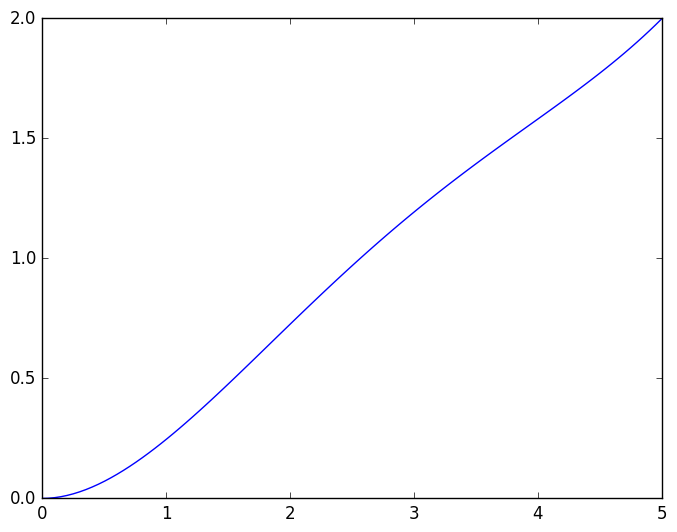

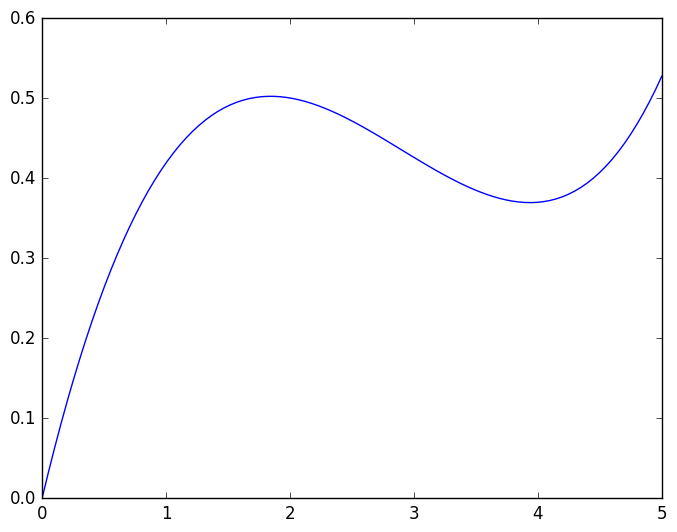

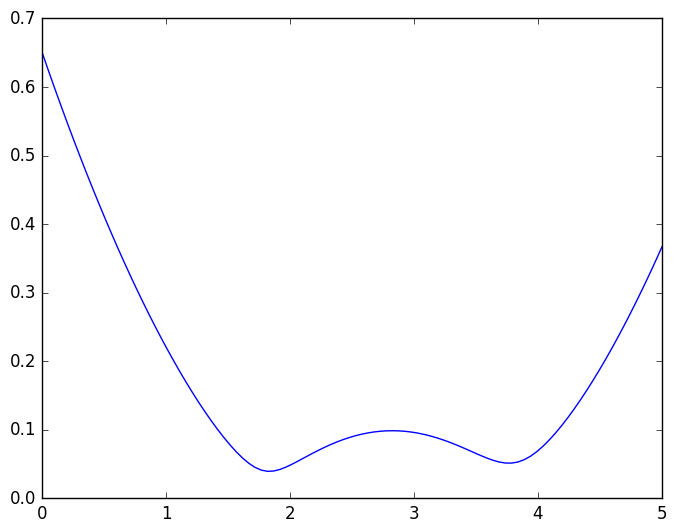

In [12]:
plot(plotTimes, sqrt(evaluate_poly(x_coeffs,1,plotTimes).^2 + evaluate_poly(y_coeffs,1,plotTimes).^2 + evaluate_poly(z_coeffs,1,plotTimes).^2));
figure()
plot(plotTimes, sqrt(evaluate_poly(x_coeffs,2,plotTimes).^2 + evaluate_poly(y_coeffs,2,plotTimes).^2 + evaluate_poly(z_coeffs,2,plotTimes).^2));
figure()
plot(plotTimes, sqrt(evaluate_poly(x_coeffs,3,plotTimes).^2 + evaluate_poly(y_coeffs,3,plotTimes).^2 + evaluate_poly(z_coeffs,3,plotTimes).^2));


In [ ]:
println(opt_mat * (x_constr)+[max_vel_vec[1];max_accel_vec[1];0])
blah = inv( R[(tot_degree-num_free+1):tot_degree, (tot_degree-num_free+1):tot_degree])
for as = 1:size(blah,1)
    println(blah[as,:])
end
println(evaluate_poly(x_coeffs,1,1))

In [ ]:
println(pcells)

In [ ]:
plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));

In [ ]:
crappy random restart
function amazingRandomRestart(costmapRR, pcellsRR, iterationsRR, perturbStepRR, x_coeffsRR, 
            y_coeffs, z_coeffs, times, dim, aggressParam, timeStep, Q,
            A_inv, x_constr, x_free,y_free, z_free, cost1, costmap, perturbStep2,endWeight,perturbStep3)
#Check Collision again
    restartCount = 0
    while(any(costmap[pcells].>254) && restartCount < 10)
        #return failure if collided still
        println("Leads to a collision so failure and random restart start")
        #Random restart
        #Record the optimized value in a variable for later gradient descent; will only work for 1 free variable at the moment
                x_free = [x_free[1];(rand()-0.5)*max_accel_vec[1];(-rand()+0.5)*0.25+final_Pos.x];
        y_free = [y_free[1]; (rand()-0.5)*max_accel_vec[2];(-rand()+0.5)*0.25+final_Pos.y];
        z_free = [z_free[1];(rand()-0.5)*max_accel_vec[3];(-rand()+0.5)*0.25+final_Pos.z];
        x_coeffs = A_inv * [x_constr; x_free];
        y_coeffs = A_inv * [y_constr; y_free];
        z_coeffs = A_inv * [z_constr; z_free];

        #Check the cost with the costmap by first finding the squares the path goes through
        #Find the cells of that the polynomial passes through; the last 5 inputs here are the three grid resolutions,
        # the dimension and an aggression param
        pcells,outOfBoundsRR = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, times, get_grid_resolution(), 
            get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
        #Check if out of bounds and avoid loop
        if(outOfBoundsRR)
            println("path went out of bounds")
            unOptimized = true;
            pcells = find(costmap == 255);
            restartCount += 1;
            continue
        else
            unOptimized = true;
        end
        #The division by three is to normalize the costs from the coefficients#
        #println(cells)
        cost1 =((x_coeffs)' * Q *(x_coeffs) + (y_coeffs)' *
Q * (y_coeffs) + (z_coeffs)' * Q * (z_coeffs))/3/lowerQeffs +
    obstacleWeight*sum(costmap[pcells])+endWeight*(abs(evaluate_poly(y_coeffs,0,1)- final_Pos.y)+abs(evaluate_poly(x_coeffs,0,1)-final_Pos.x)
 +abs(evaluate_poly(z_coeffs,0,1)-final_Pos.z)*(dim == 3));
        x_coeffs, y_coeffs, z_coeffs, pcells, outOfBounds = crudyGradientDescent2(iterations, perturbStep, x_coeffs, 
            y_coeffs, z_coeffs, times, dim, aggressParam, timeStep, Q,
            A_inv, x_constr, x_free,y_free, z_free, cost1, costmap, perturbStep2,endWeight,perturbStep3)
        restartCount+=1;
    end
    if(restartCount >= 10)
        println("path fails")
    end
    
    return x_coeffs, y_coeffs, z_coeffs, cells, outOfBounds, x_free,y_free, z_free;
end